# Title of Database: Wall-Following navigation task with mobile robot SCITOS-G5

The data were collected as the SCITOS G5 navigates through the room following the wall in a clockwise
direction, for 4 rounds. To navigate, the robot uses 24 ultrasound sensors arranged circularly around its "waist". 
The numbering of the ultrasound sensors starts at the front of the robot and increases in clockwise direction.

In [1]:
# modules
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard
from __future__ import print_function
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn import preprocessing
from keras import layers
from keras import initializers
from matplotlib import axes
from matplotlib import rc

import keras
import matplotlib.pyplot as plt
import numpy as np
import math
import pydot
import graphviz
import pandas as pd
import IPython

Using TensorFlow backend.


In [2]:
%matplotlib inline
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 20}

rc('font', **font)

## Import and basic data inspection

In [3]:
# import
data_raw = pd.read_csv('data/sensor_readings_24.csv', sep=",", header=None)
data = data_raw.copy()

The dataframe consists of only positive values and the classes are encoded as strings in the variable with index `24`

In [4]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.438,0.498,3.625,3.645,5.0,2.918,5.0,2.351,2.332,2.643,...,0.593,0.502,0.493,0.504,0.445,0.431,0.444,0.440,0.429,Slight-Right-Turn
1,0.438,0.498,3.625,3.648,5.0,2.918,5.0,2.637,2.332,2.649,...,0.592,0.502,0.493,0.504,0.449,0.431,0.444,0.443,0.429,Slight-Right-Turn
2,0.438,0.498,3.625,3.629,5.0,2.918,5.0,2.637,2.334,2.643,...,0.593,0.502,0.493,0.504,0.449,0.431,0.444,0.446,0.429,Slight-Right-Turn
3,0.437,0.501,3.625,3.626,5.0,2.918,5.0,2.353,2.334,2.642,...,0.593,0.502,0.493,0.504,0.449,0.431,0.444,0.444,0.429,Slight-Right-Turn
4,0.438,0.498,3.626,3.629,5.0,2.918,5.0,2.640,2.334,2.639,...,0.592,0.502,0.493,0.504,0.449,0.431,0.444,0.441,0.429,Slight-Right-Turn


Whats the distribution of the classes?

In [5]:
df_tab = data_raw
df_tab[24] = df_tab[24].astype('category')
tab = pd.crosstab(index=df_tab[24], columns="frequency")
tab.index.name = 'Class/Direction'
tab/tab.sum()

col_0,frequency
Class/Direction,
Move-Forward,0.404142
Sharp-Right-Turn,0.384348
Slight-Left-Turn,0.060117
Slight-Right-Turn,0.151393


The `Move_Forward` and the `Sharp-Right-Turn` Class combine nearly 80% of all observated classes. So it might happen, that the accuracy may still be high with around 75% although most of the features are eliminated.

## Preprocessing

**0. Mapping integer values to the classes.**

In [6]:
mapping = {key: value for (key, value) in zip(data[24].unique(), range(len(data[24].unique())))}
data.replace({24:mapping}, inplace=True)

In [7]:
data[24].unique()

array([0, 1, 2, 3], dtype=int64)

**1. Take a random sample of 90% of the rows from the dataframe. To ensure reproducability the `random_state` variable is set. The other 10% are placed aside for validation after training. The last column is the class column and is stored in the y variables respectively.**

In [8]:
data_train = data.sample(frac=0.9, random_state=42)
data_val = data.drop(data_train.index)

df_x_train = data_train.iloc[:,:-1]
df_y_train = data_train.iloc[:,-1]

df_x_val = data_val.iloc[:,:-1]
df_y_val = data_val.iloc[:,-1]

**2. Normalization between 0 and 1**

In [9]:
x_train = df_x_train.values
x_train = (x_train - x_train.min()) / (x_train.max() - x_train.min())
y_train = df_y_train.values

x_val = df_x_val.values
x_val = (x_val - x_val.min()) / (x_val.max() - x_val.min())
y_val = df_y_val.values

**3. Make useful categorical variables out of the single column data by one-hot encoding it.**

In [10]:
y_train = keras.utils.to_categorical(y_train, 4)
y_val = keras.utils.to_categorical(y_val, 4)

** 4. Set Global Parameters**

In [35]:
epochsize = 150
batchsize = 24
shuffle = False
dropout = 0.1
num_classes = 4
input_dim = x_train.shape[1]
hidden1_dim = 30
hidden2_dim = 30

## Train Neural Net

*Due to a tight schedule we will not perform any cross validation. So it might happen that our accuracy estimators lack a little bit in potential of generalization. We shall live with that. Another setup of experiments would be, that we loop over some different dataframes samples up in the preprocessing steps and repeat all the steps below to finally average the results.*

The dimension of the hidden layers are set arbitrarily but some runs have shown that 30 is a good number. The `input_dim` Variable is set to 24 because initially there are 24 features. The aim is to build the best possible neural net.

#### Optimizer

RMSprop is a mini batch gradient descent algorithm which divides the gradient by a running average of the learning rate. More information: http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf

The weights are initialized by a normal distribution with mean 0 and standard deviation of 0.05.

In [39]:
input_data = Input(shape=(input_dim,), dtype='float32', name='main_input')
hidden_layer1 = Dense(hidden1_dim, activation='relu', input_shape=(input_dim,), kernel_initializer='normal')(input_data)
dropout1 = Dropout(dropout)(hidden_layer1)
hidden_layer2 = Dense(hidden2_dim, activation='relu', input_shape=(input_dim,), kernel_initializer='normal')(dropout1)
dropout2 = Dropout(dropout)(hidden_layer2)
output_layer = Dense(num_classes, activation='softmax', kernel_initializer='normal')(dropout2)

model = Model(inputs=input_data, outputs=output_layer)

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [ ]:
plot_model(model, to_file='images/robo1_nn.png', show_shapes=True, show_layer_names=True)

In [ ]:
IPython.display.Image("images/robo1_nn.png")

In [40]:
model.fit(x_train, y_train, 
          batch_size=batchsize,
          epochs=epochsize,
          verbose=0,
          shuffle=shuffle,
          validation_split=0.05)
nn_score = model.evaluate(x_val, y_val)[1]
print(nn_score)

546/546 [==============================] - 0s 42us/step
0.941391941392


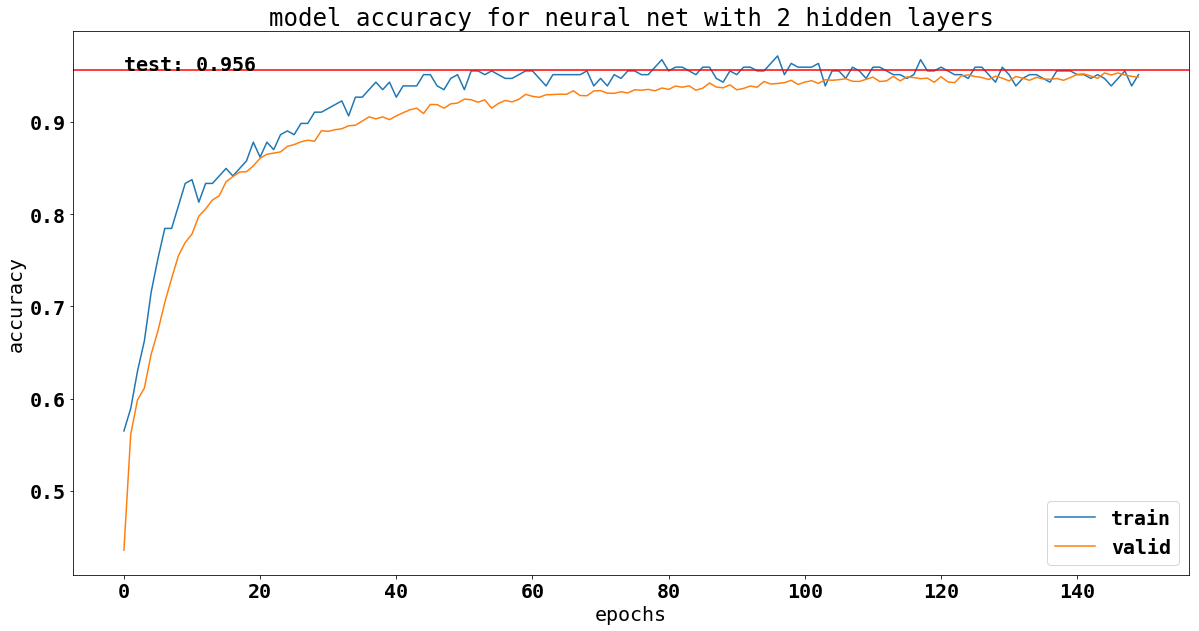

In [19]:
fig = plt.figure(figsize=(20,10))
plt.plot(model.history.history['val_acc'])
plt.plot(model.history.history['acc'])
plt.axhline(y=nn_score, c="red")
plt.text(0, nn_score, "test: " + str(round(nn_score, 4)), fontdict=font)
plt.title('model accuracy for neural net with 2 hidden layers')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

#### Comparison

The following data is from a paper published in March 2017. You can find that here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5375835/

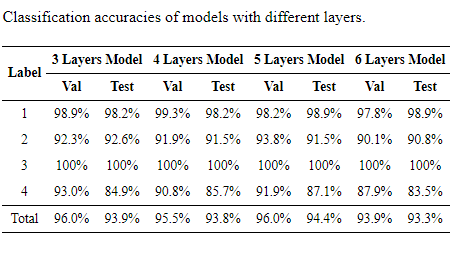

In [207]:
IPython.display.Image("images/2018-01-25 18_44_01-PubMed Central, Table 2_ Sensors (Basel). 2017 Mar; 17(3)_ 549. Published online.png")

One can easily see that our results are better.

## Dimensionality Reduction with Single Hidden Layer Autoencoder

In [21]:
encoder_dim = 8
hidden1_dim = 30
hidden2_dim = 30

In [22]:
main_input = Input(shape=(input_dim,), dtype='float32', name='main_input')

encoding_layer = Dense(encoder_dim, activation='relu', kernel_initializer='normal')
encoding_layer_output = encoding_layer(main_input)
decoding_layer_output = Dense(input_dim
                              ,activation='sigmoid'
                              ,name='decoder_output'
                              ,kernel_initializer='normal')(encoding_layer_output)

x = Dense(hidden1_dim, activation='relu', kernel_initializer='normal')(encoding_layer_output)
x = Dropout(dropout)(x)
x = Dense(hidden2_dim, activation='relu', kernel_initializer='normal')(x)
x = Dropout(dropout)(x)

classifier_output = Dense(num_classes
                          ,activation='softmax'
                          ,name='main_output'
                          ,kernel_initializer='normal')(x)

auto_classifier = Model(inputs=main_input, outputs=[classifier_output, decoding_layer_output])

auto_classifier.compile(optimizer=RMSprop(),
                        loss={'main_output': 'categorical_crossentropy', 'decoder_output': 'mean_squared_error'},
                        loss_weights={'main_output': 1., 'decoder_output': 1.},
                        metrics=['accuracy'])

In [23]:
plot_model(auto_classifier, to_file='images/robo4_auto_class_LR.png', show_shapes=True, show_layer_names=True)

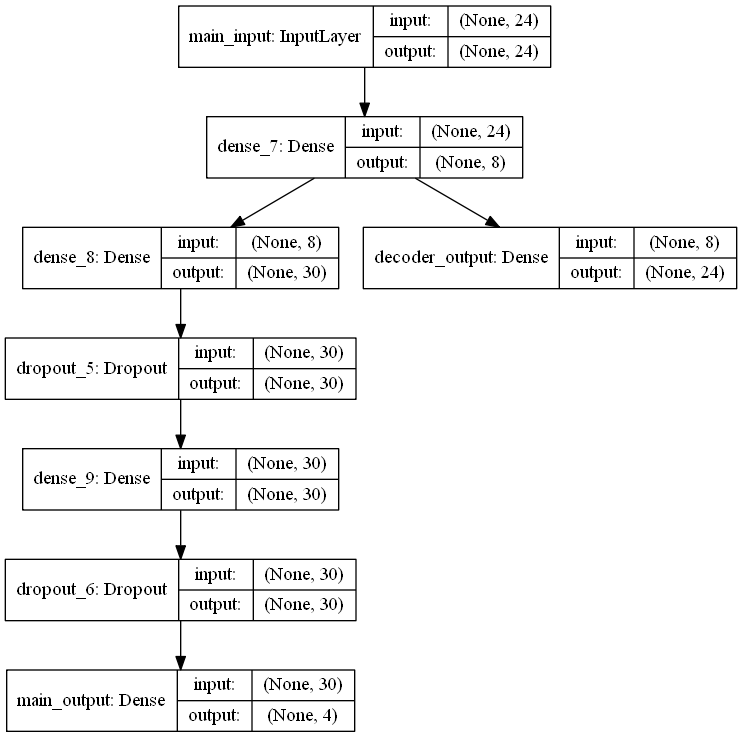

In [24]:
IPython.display.Image("images/robo4_auto_class_LR.png")

In [25]:
auto_classifier.fit({'main_input': x_train},
                    {'main_output': y_train, 'decoder_output': x_train},
                    epochs=epochsize, 
                    batch_size=batchsize,
                    shuffle=shuffle,
                    validation_split=0.05,
                    verbose=0)

score = auto_classifier.evaluate(x=x_val, y=[y_val, x_val], verbose=1)[3]
print(score)

546/546 [==============================] - 0s 41us/step
0.906593406593


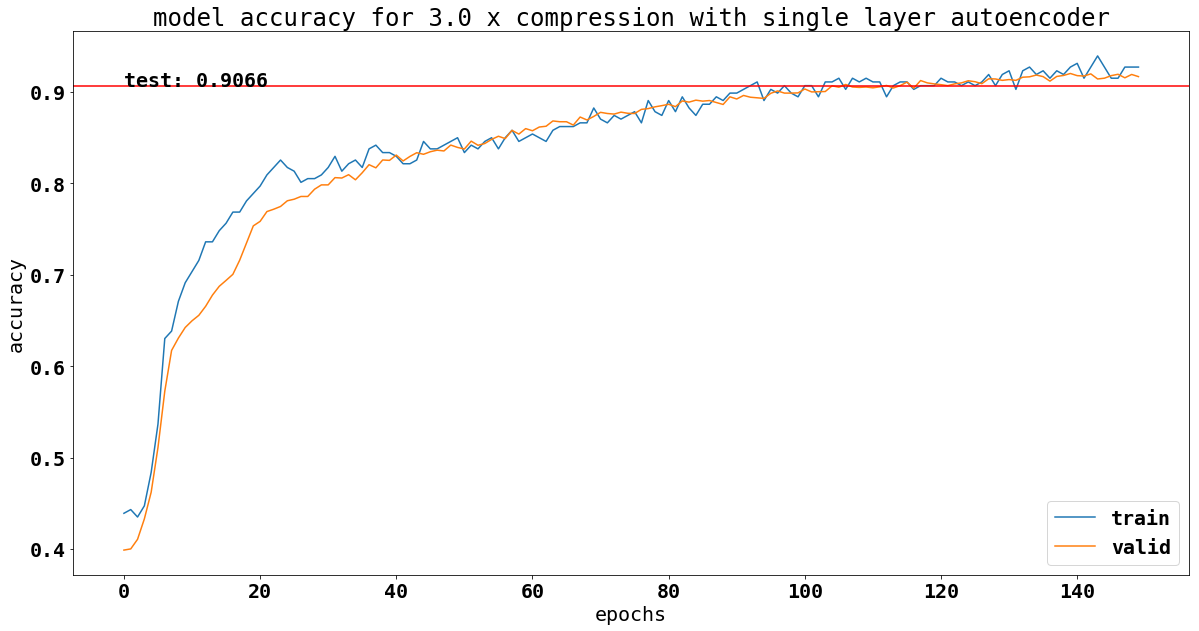

In [26]:
fig = plt.figure(figsize=(20,10))
plt.plot(auto_classifier.history.history['val_main_output_acc'])
plt.plot(auto_classifier.history.history['main_output_acc'])
plt.axhline(y=score, c="red")
plt.text(0, score, "test: " + str(round(score, 4)), fontdict=font)
plt.title('model accuracy for ' + str(round(input_dim/encoder_dim, 2)) +  ' x compression with single layer autoencoder')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

## Dimensionality reduction with stacked (multi hidden layer) autoencoder

In [31]:
encoder_dim1 = 16
encoder_dim2 = 8
decoder_dim1 = 16

In [32]:
main_input = Input(shape=(input_dim,), dtype='float32', name='main_input')

encoding_layer1 = Dense(encoder_dim1, activation='relu', kernel_initializer='normal')(main_input)
encoding_layer2 = Dense(encoder_dim2, activation='relu', kernel_initializer='normal')(encoding_layer1)

decoding_layer1 = Dense(decoder_dim1
                        ,activation='relu'
                        ,kernel_initializer='normal')(encoding_layer2)
decoding_layer2 = Dense(input_dim
                        ,activation='sigmoid'
                        ,name='decoder_output'
                        ,kernel_initializer='normal')(decoding_layer1)

x = Dense(hidden1_dim, activation='relu', kernel_initializer='normal')(encoding_layer2)
x = Dropout(dropout)(x)
x = Dense(hidden2_dim, activation='relu', kernel_initializer='normal')(x)
x = Dropout(dropout)(x)

classifier_output = Dense(num_classes
                          ,activation='softmax'
                          ,name='main_output'
                          ,kernel_initializer='normal')(x)

stacked_auto_classifier = Model(inputs=main_input, outputs=[classifier_output, decoding_layer2])

stacked_auto_classifier.compile(optimizer=RMSprop(),
                        loss={'main_output': 'categorical_crossentropy', 'decoder_output': 'mean_squared_error'},
                        loss_weights={'main_output': 1., 'decoder_output': 1.},
                        metrics=['accuracy'])

In [29]:
plot_model(stacked_auto_classifier, to_file='images/stacked__auto_class.png', show_shapes=True, show_layer_names=True)

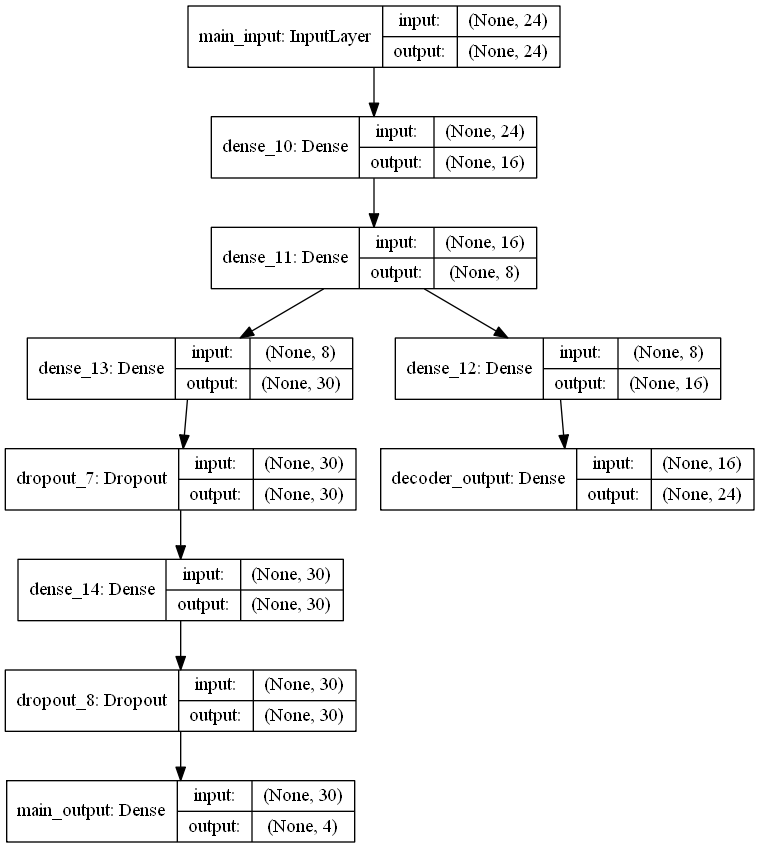

In [30]:
IPython.display.Image("images/stacked__auto_class.png")

In [33]:
stacked_auto_classifier.fit({'main_input': x_train},
                            {'main_output': y_train, 'decoder_output': x_train},
                            epochs=epochsize, 
                            batch_size=batchsize,
                            shuffle=shuffle,
                            validation_split=0.05,
                            verbose=0)

stacked_score = stacked_auto_classifier.evaluate(x=x_val, y=[y_val, x_val], verbose=1)[3]
print(stacked_score)

546/546 [==============================] - 0s 54us/step
0.895604395604


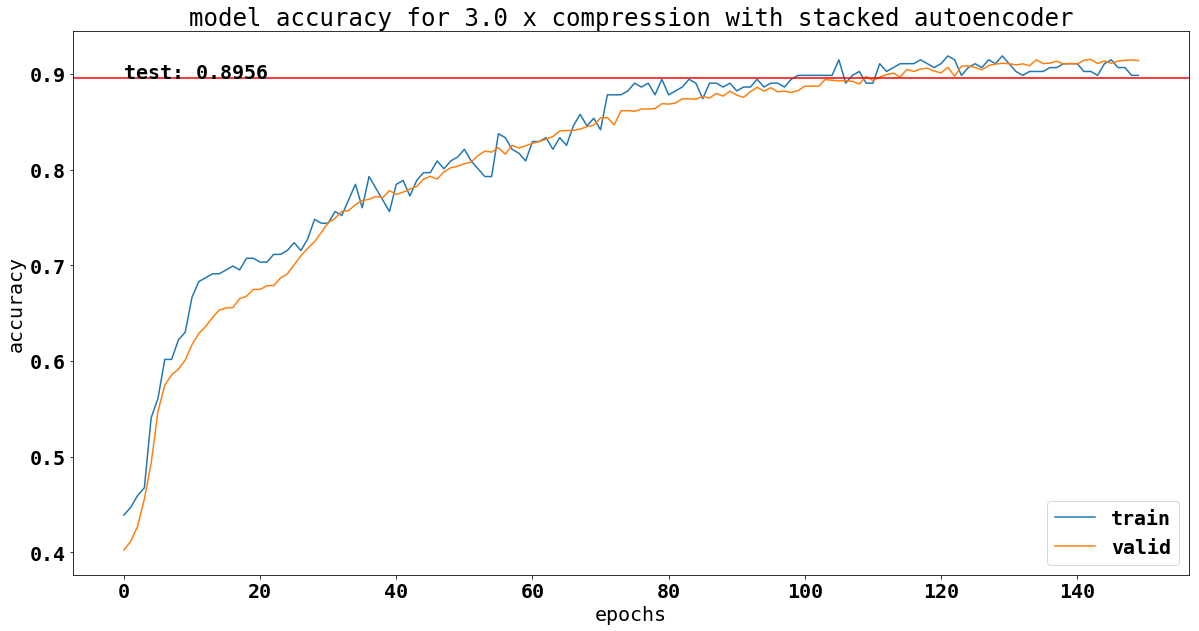

In [34]:
fig = plt.figure(figsize=(20,10))
plt.plot(stacked_auto_classifier.history.history['val_main_output_acc'])
plt.plot(stacked_auto_classifier.history.history['main_output_acc'])
plt.axhline(y=stacked_score, c="red")
plt.text(0, stacked_score, "test: " + str(round(stacked_score, 4)), fontdict=font)
plt.title('model accuracy for ' + str(round(input_dim/encoder_dim, 2)) +  ' x compression with stacked autoencoder')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

## Whats the best dimensionality reduction with single autoencoder?

In [36]:
# the initial coding dimension s.t. there is no feature selection at the beginning
encoding_dim = input_dim
result3 = {'encoding_dim': []
           ,'auto_classifier_acc': []}

In [ ]:
while encoding_dim > 0:
    main_input = Input(shape=(input_dim,), dtype='float32', name='main_input')

    encoding_layer = Dense(encoding_dim, activation='relu', name='encoder', kernel_initializer='normal')
    encoding_layer_output = encoding_layer(main_input)
    decoding_layer_output = Dense(input_dim, activation='sigmoid'
                                  ,name='decoder_output'
                                  ,kernel_initializer='normal')(encoding_layer_output)

    x = Dense(hidden1_dim, activation='relu', kernel_initializer='normal')(encoding_layer_output)
    x = Dropout(dropout)(x)
    x = Dense(hidden2_dim, activation='relu', kernel_initializer='normal')(x)
    x = Dropout(dropout)(x)

    classifier_output = Dense(num_classes, activation='softmax', name='main_output', kernel_initializer='normal')(x)

    auto_classifier = Model(inputs=main_input, outputs=[classifier_output, decoding_layer_output])

    auto_classifier.compile(optimizer=RMSprop(),
                            loss={'main_output': 'categorical_crossentropy', 'decoder_output': 'mean_squared_error'},
                            loss_weights={'main_output': 1., 'decoder_output': 1.},
                            metrics=['accuracy'])

    auto_classifier.fit({'main_input': x_train},
                        {'main_output': y_train, 'decoder_output': x_train},
                        epochs=epochsize, 
                        batch_size=batchsize,
                        shuffle=shuffle,
                        validation_split=0.05,
                        verbose=0)

    accuracy = auto_classifier.evaluate(x=x_val, y=[y_val, x_val], verbose=1)[3]
    result3['encoding_dim'].append(encoding_dim)
    result3['auto_classifier_acc'].append(accuracy)

    encoding_dim -=1
    print(result3)

In [41]:
result_df = pd.DataFrame(result3)
result_df['neural_net_acc'] = nn_score
result_df

,auto_classifier_acc,encoding_dim,neural_net_acc
0,0.917582,24,0.941392
1,0.934066,23,0.941392
2,0.928571,22,0.941392
3,0.930403,21,0.941392
4,0.934066,20,0.941392
5,0.930403,19,0.941392
6,0.932234,18,0.941392
7,0.935897,17,0.941392
8,0.941392,16,0.941392
9,0.924908,15,0.941392


(0.6, 1)

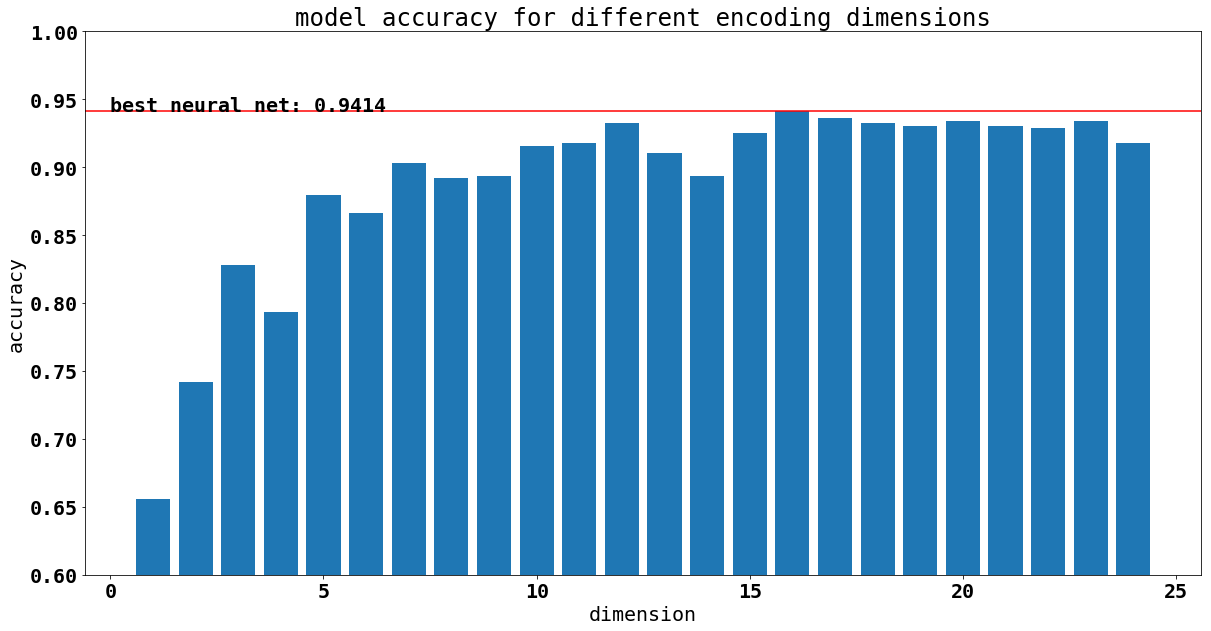

In [47]:
fig = plt.figure(figsize=(20,10))
plt.bar(result_df['encoding_dim'], result_df['auto_classifier_acc'])
plt.axhline(y=result_df['neural_net_acc'][0], c="red")
plt.text(0, result_df['neural_net_acc'][0], "best neural net: " + str(round(result_df['neural_net_acc'][0], 4))
         ,fontdict=font)
plt.title('model accuracy for different encoding dimensions')
plt.ylabel('accuracy')
plt.xlabel('dimension')
plt.ylim(0.6, 1)

In [43]:
result_df.to_csv('results/robo_results.csv')

# Experimental area (not for presentation)

The indices of the extracted features are:

In [185]:
encoding_weights = encoding_layer.get_weights()
sum_of_weights = {index: item.sum() for (index, item) in enumerate(encoding_weights[0])}

weights = sum_of_weights
features = []
for i in range(encoder_dim1):
    max_key = max(weights, key=lambda key: weights[key])
    features.append(max_key)
    del weights[max_key]
    
print(features)

[12, 6, 20, 0, 5, 1, 17, 2, 23, 22, 21, 8, 3]


## Check the neural net performance with new selected features

In [180]:
x_train_selected = np.array([x[features] for x in x_train])
x_val_selected = np.array([x[features] for x in x_val])

In [182]:
input_dim = x_train_selected.shape[1]
hidden1_dim = 26
hidden2_dim = 26

In [183]:
result3 = []

for i in range(1,4):
    model_new = Sequential()
    model_new.add(Dense(hidden1_dim, activation='relu', input_shape=(input_dim,)))
    model_new.add(Dense(hidden2_dim, activation='relu'))
    model_new.add(Dense(num_classes, activation='softmax'))

    model_new.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

    model_new.fit(x_train_selected, y_train, 
              batch_size=batchsize,
              epochs=epochsize,
              verbose=0,
              shuffle=shuffle,
              validation_split=0.1)
    score = model_new.evaluate(x_val_selected, y_val)[1]
    result3.append(score)
    print(result3)
print(np.mean(result3))

546/546 [==============================] - 0s 100us/step
[0.81135531135531136]
546/546 [==============================] - 0s 110us/step
[0.81135531135531136, 0.79853479853479858]
546/546 [==============================] - 0s 110us/step
[0.81135531135531136, 0.79853479853479858, 0.78388278388278387]
0.797924297924


## Finding good features

"Is there a good number of features for the Robo- Dataset?" For that we create a loop over some numbers (i.e. dimension of hidden layer from the single autoencoder) and get the respective result.

The architecture within those loops is quite special. For that we recommend to have a look at the neural net visualization below.

#### The parameters for the ensemble training

In [200]:
# the initial coding dimension s.t. there is no feature selection at the beginning
encoding_dim = 24
# dimension of the neural net layer1
hidden1_dim = 30
# dimension of the second neural net layer
hidden2_dim = 30
epoch_size = 150
batch_size = 24
shuffle = False
result2 = {'encoding_dim/features': []
           ,'compression_level': []
           ,'auto_classifier_acc': []
           ,'selected_classifier_acc': []
           ,'features': []}

The idea is:
- reduce the number of features `encoding_dim` iteratively by training an auto_classifier network
- after training, the weights of the first layer are analyzed.
- therefore sum up the weights for each input node and take the `encoding_dim` number as new features
- test the new features with the pre- defined neural net and see which selection is best.

In [ ]:
while encoding_dim > 0:
    main_input = Input(shape=(input_dim,), dtype='float32', name='main_input')

    encoding_layer = Dense(encoding_dim, activation='relu', name='encoder', kernel_initializer='normal')
    encoding_layer_output = encoding_layer(main_input)
    decoding_layer_output = Dense(input_dim, activation='sigmoid'
                                  ,name='decoder_output'
                                  ,kernel_initializer='normal')(encoding_layer_output)

    x = Dense(hidden1_dim, activation='relu', kernel_initializer='normal')(encoding_layer_output)
    x = Dense(hidden2_dim, activation='relu', kernel_initializer='normal')(x)

    classifier_output = Dense(num_classes, activation='softmax', name='main_output', kernel_initializer='normal')(x)

    auto_classifier = Model(inputs=main_input, outputs=[classifier_output, decoding_layer_output])

    auto_classifier.compile(optimizer=RMSprop(),
                            loss={'main_output': 'categorical_crossentropy', 'decoder_output': 'mean_squared_error'},
                            loss_weights={'main_output': 1., 'decoder_output': 1.},
                            metrics=['accuracy'])

    auto_classifier.fit({'main_input': x_train},
                        {'main_output': y_train, 'decoder_output': x_train},
                        epochs=epoch_size, 
                        batch_size=batch_size,
                        shuffle=shuffle,
                        validation_split=0.1,
                        verbose=0)

    accuracy = auto_classifier.evaluate(x=x_val, y=[y_val, x_val], verbose=1)[3]
    result2['encoding_dim/features'].append(encoding_dim)
    result2['compression_level'].append(1 - encoding_dim/24)
    result2['auto_classifier_acc'].append(accuracy)

    encoding_weights = encoding_layer.get_weights()
    sum_of_weights = {index: item.sum() for (index, item) in enumerate(encoding_weights[0])}

    weights = sum_of_weights
    features = []
    for i in range(encoding_dim):
        max_key = max(weights, key=lambda key: weights[key])
        features.append(max_key)
        del weights[max_key]
    
    result2['features'].append(features)
    x_train_selected = np.array([x[features] for x in x_train])
    x_val_selected = np.array([x[features] for x in x_val])

    input_dim_new = x_train_selected.shape[1]
    
    accuracy_list = []
    for i in range(1):
        model_new = Sequential()
        model_new.add(Dense(hidden1_dim, activation='relu', input_shape=(input_dim_new,), kernel_initializer='normal'))
        model_new.add(Dense(hidden2_dim, activation='relu', kernel_initializer='normal'))
        model_new.add(Dense(num_classes, activation='softmax', kernel_initializer='normal'))

        model_new.compile(loss='categorical_crossentropy',
                      optimizer=RMSprop(),
                      metrics=['accuracy'])

        model_new.fit(x_train_selected, y_train, 
                  batch_size=batch_size,
                  epochs=epoch_size,
                  verbose=0,
                  shuffle=shuffle,
                  validation_split=0.1)
        score = model_new.evaluate(x_val_selected, y_val)[1]
        accuracy_list.append(score)

    result2['selected_classifier_acc'].append(np.mean(accuracy_list))
    encoding_dim -=1
    print(result2)

#### Summary

In [149]:
auto_classifier.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 24)           0                                            
__________________________________________________________________________________________________
dense_622 (Dense)               (None, 13)           325         main_input[0][0]                 
__________________________________________________________________________________________________
dense_623 (Dense)               (None, 30)           420         dense_622[0][0]                  
__________________________________________________________________________________________________
dense_624 (Dense)               (None, 30)           930         dense_623[0][0]                  
__________________________________________________________________________________________________
main_outpu

#### Architecture

In [150]:
plot_model(auto_classifier, to_file='images/robo2_auto_class_LR.png', show_shapes=True, show_layer_names=True, rankdir='LR')

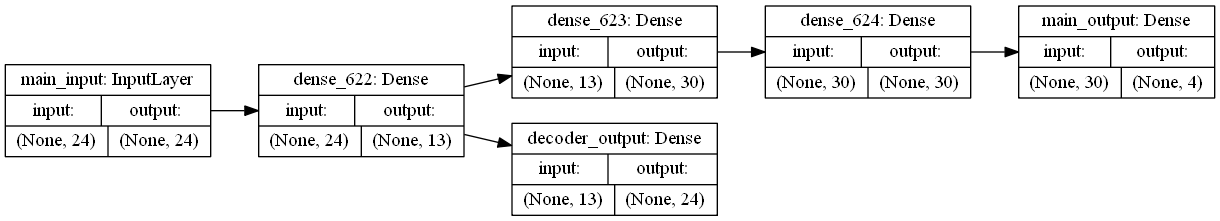

In [210]:
IPython.display.Image("images/robo2_auto_class_LR.png")

### Results

In [202]:
result_df = pd.DataFrame(result2)
result_df['neural_net_acc'] = 0.949938949939
result_df

,auto_classifier_acc,compression_level,encoding_dim/features,features,selected_classifier_acc,neural_net_acc
0,0.915751,0.000000,24,"[12, 10, 8, 6, 1, 20, 4, 3, 5, 22, 21, 7, 9, 1...",0.932234,0.949939
1,0.943223,0.041667,23,"[12, 8, 20, 7, 11, 6, 10, 15, 4, 21, 22, 1, 5,...",0.924908,0.949939
2,0.924908,0.083333,22,"[8, 12, 6, 20, 1, 21, 7, 2, 4, 5, 3, 10, 9, 22...",0.919414,0.949939
3,0.904762,0.125000,21,"[20, 8, 12, 2, 6, 3, 5, 1, 10, 13, 21, 4, 7, 0...",0.853480,0.949939
4,0.921245,0.166667,20,"[12, 8, 4, 6, 10, 5, 3, 21, 9, 2, 7, 1, 22, 20...",0.888278,0.949939
5,0.921245,0.208333,19,"[12, 8, 4, 6, 2, 5, 7, 21, 1, 3, 20, 9, 22, 10...",0.836996,0.949939
6,0.913919,0.250000,18,"[8, 12, 6, 1, 2, 5, 7, 4, 3, 10, 9, 21, 0, 20,...",0.804029,0.949939
7,0.902930,0.291667,17,"[8, 12, 4, 6, 3, 2, 20, 5, 1, 11, 21, 15, 7, 1...",0.796703,0.949939
8,0.937729,0.333333,16,"[8, 12, 1, 6, 2, 4, 3, 7, 9, 10, 20, 22, 5, 15...",0.802198,0.949939
9,0.917582,0.375000,15,"[4, 22, 8, 6, 1, 3, 10, 0, 2, 20, 5, 9, 12, 7,...",0.804029,0.949939


In [48]:
result_df.to_csv('results/robo_results.csv')

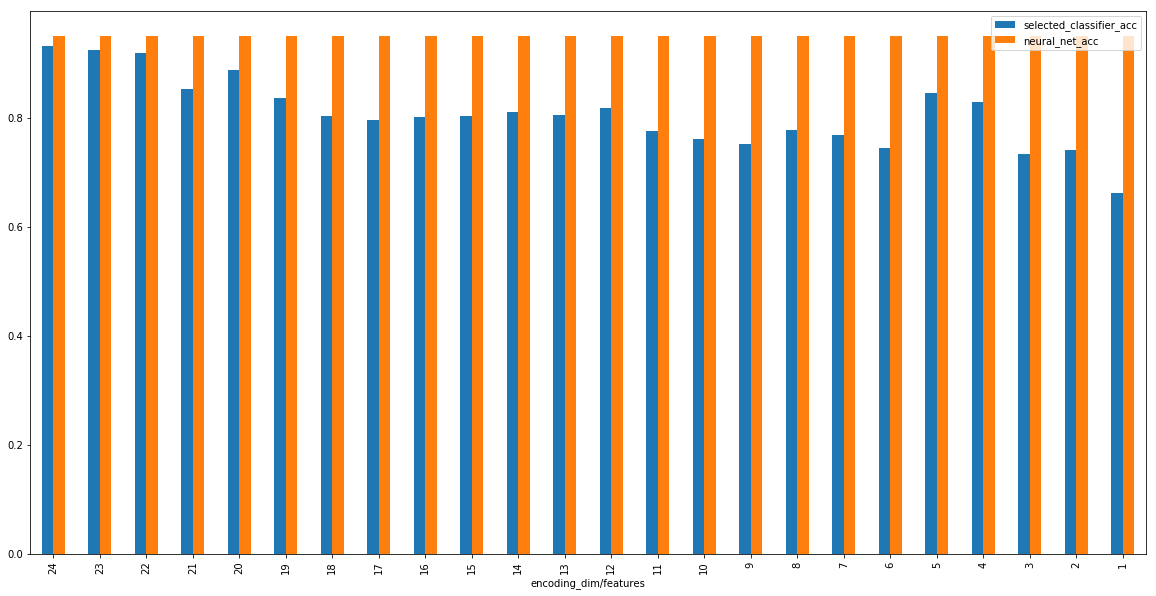

In [204]:
result_df.plot(x='encoding_dim/features', y=['selected_classifier_acc', 'neural_net_acc'], kind='bar', figsize=(20,10))

Obviously the procedure yields the best performance for 13 features. That corresponds to a compression of about 45%.
To go a little bit deeper we analyze the confusion matrix of the 13- feature version of the Neural Net.